# Assignment 3: DLT, Two-View Geometry and PnP

Roll number: \<Roll number here\>

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment. 
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- Make sure any extra files you that you need to submit, place it in *'results'* folder.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- We recommend early start of this assignment. As this assignment is quite heavy.
- **Download the data folder from this [link](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/ayush_sharma_students_iiit_ac_in/ErFTcJxQfO1KhaCo3m_9erwBj8M6-eeN8AO8e1bl4MXcBg?e=pdJR7F)**
- The **deadline** for this assignment is on **4/11/2022 at 11:55pm**.
- Plagiarism is **strictly prohibited**.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
np.random.seed(0)

In [2]:
import cv2
import importlib
import matplotlib.pyplot as plt
import json
from copy import deepcopy
import numpy as np
import helper_utils.dlt_related as dlt_related
importlib.reload(dlt_related)
import helper_utils.annotate_images as img_helper
importlib.reload(img_helper)
import helper_utils.estimation_related as est_related
importlib.reload(est_related)

<module 'helper_utils.estimation_related' from '/home/anmolagarwal/Desktop/mr_assignment_3/helper_utils/estimation_related.py'>

# 3. PnP

This part of the assignment deals new camera pose measurement. Mention the **least number of correspondences** that PnP requires. Your task in this part is to recover new virtual camera's pose using an iterative Perspective-from-n-Points (PnP) algorithm. Follow the below points for other deliverables:-

### TODO 1:


1. Since, you already have 3D points from the previous part. View them in open3D. Synthesize a new image taken by a virtual monocular camera fixed at any arbitrary position and orientation. Generate 2D-3D corresspondences using ground truth camera pose extrinsic. You can use camera intrinsic from previous part.

##### Theory
* P0P = 6 DOF
* P1P = 4 DOF
* P2P = 2 DOF
* P3P = 0 DOF

The more the points are away from coplanarity, the better it would be.

In [3]:
# These two libraries are recommended. You're free 
# to use other libraries but donot use function 
# that solves the probel out of the box itself.

# import sympy as sp
# from IPython.display import display

##### Take Intrinsic camera matrix from data file

382.1996765136719     381.8395690917969     312.7102355957031    247.72047424316406    1000.0

##### Fx, Fy, Cx, Cy, Scaling factor

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e712d4b11c471fba8d70b4ae2f8790328040c6fd" alt="image 1" width="400"/>

In [4]:
f_x = 382.1996765136719
f_y = 381.83956909
c_x = 312.7102355957031
c_y = 247.72047424316406
scaling_fac = 1000.0

In [5]:
K_mat = np.array([
    [f_x, scaling_fac, c_x,0],
    [0, f_y, c_y,0],
    [0, 0, 1,0]
    
])

In [6]:
M_int = K_mat

#### generate a random rotation and translation for testing purposes

In [7]:
from scipy.stats import ortho_group

In [8]:
rot = np.array(ortho_group.rvs(dim=3))

In [9]:
np.linalg.det(rot)

0.9999999999999999

In [10]:
M_ext=np.zeros((4,4))

##### Setting a random translation and equalizing with the rotation generated earlier

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/8debf2c38beb4c25685cd503a90d1a4edfb10a14" alt="image 1" width="400"/>

In [11]:
M_ext[0:3, 3]=np.random.rand(3)
M_ext[0:3, 0:3]=rot
M_ext[-1, -1]= 1

In [12]:
with np.printoptions(suppress=True):
    print(M_ext)

[[ 0.85771824  0.45413047  0.24100817  0.43758721]
 [ 0.1945646  -0.720634    0.66545567  0.891773  ]
 [ 0.47588238 -0.52388181 -0.70645864  0.96366276]
 [ 0.          0.          0.          1.        ]]


##### Calculate a camera projection matrix from these intrinsic and extrinsic matrices

In [13]:
P_mat = M_int@M_ext

In [14]:
with np.printoptions(suppress=True):
    print(P_mat)

[[ 671.19752298 -710.88868964  536.65206629 1360.36590024]
 [ 192.17827046 -404.94282779   79.09303679  579.23321439]
 [   0.47588238   -0.52388181   -0.70645864    0.96366276]]


##### Generate artficial correspondences

In [15]:
NUM_POINTS = 120
X_world = []
X_img  = []
for i in range(NUM_POINTS):
    sample_world_point=np.random.rand(4)
    image_point=P_mat @ sample_world_point
    X_world.append(sample_world_point)
    X_img.append(image_point)
X_world = np.array(X_world)
X_img = np.array(X_img)

In [16]:
X_world.shape

(120, 4)

In [17]:
X_img.shape

(120, 3)

##### Just sanity checking the validity of the projection matrix

In [18]:
# just rechecking validity of projection matrix
with np.printoptions(suppress=True):
    print(P_mat@X_world.T - X_img.T)

[[-0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0. -0.  0.  0.  0.  0.
   0.  0.  0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.
   0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.
  -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.
   0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  -0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0. -0. -0.  0.
   0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.
   0.  0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0. -0.
   0.  0.  0.  0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.
   0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0. -0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0.  0. 

### Start optimization

##### I am using the notation as used in the book by `Boyd`

## Normalizing 2D parameters
The relation between P, K, R and C is:
$$P = KR\begin{bmatrix}I_{3\times3} & -C\end{bmatrix}$$

Now, instead of solving: $x=P \times X$, we solve for:
$$K^{-1} x = R\begin{bmatrix}I_{3\times3} & -C\end{bmatrix}  X$$

where $K$, $x$ and $X$ are known. 

In [19]:
X_img.shape

(120, 3)

In [20]:
normalized_X_img = np.linalg.inv(K_mat[:3, :3])@X_img.T
normalized_X_img = normalized_X_img.T

In [21]:
normalized_X_img.shape

(120, 3)

##### Calculating the residual which we helpful in finding how error rudces via convergence

In [22]:
def get_error(normalized_img_points, world_points, current_m_ext_guess):
    e = residual(normalized_img_points, world_points, current_m_ext_guess)
    
    # ignoring the weight matrix existence for now
    err = e @ e.T 
    return err

In [23]:
def residual(normalized_img_points, world_points, current_m_ext_guess):
    res = []
    P = deepcopy(current_m_ext_guess.reshape((3,4)))
    
    for i in range(normalized_img_points.shape[0]):
        #print("i is ", i)
        proj_point = P @ world_points[i]
        norm = (normalized_img_points[i] - proj_point)
        # norm is across all dimensions
        res.extend(norm)
    #print("res is ", res)
    return np.array(res)

# Derivation of jacobian can be found in `/docs/jacobian calculation.pdf`

In [24]:
def jacobian(points_2d, points_3d, P_guess):
    
    # for each point, we can estimate error across all 3 dimensions ie dx, dy, dz
    J = np.zeros((3 * points_2d.shape[0], 12))
    
    for i in range(points_2d.shape[0]):
        b1, b2, b3 = points_2d[i]
        x, y, z, t = points_3d[i]
        
        idx = 3 * i
        J[idx][0]  = -x
        J[idx][1]  = -y
        J[idx][2]  = -z
        J[idx][3]  = -t
        
        idx = 3 * i + 1
        J[idx][4]  = -x
        J[idx][5]  = -y
        J[idx][6]  = -z
        J[idx][7]  = -t
        
        idx = 3 * i + 2
        J[idx][8]  = -x
        J[idx][9]  = -y
        J[idx][10]  = -z
        J[idx][11]  = -t

        
    return J

##### Sanity check on residual ie the value of residual on ground truth should be zero

In [25]:
res = residual(normalized_X_img, X_world,M_ext[:3, :])

##### Find current jacobian

In [26]:
jac = jacobian(normalized_X_img, X_world, M_ext[:3, :])

In [27]:
with np.printoptions(suppress=True):
    print(jac[5:, :3])

[[ 0.          0.          0.        ]
 [-0.83261985 -0.77815675 -0.87001215]
 [ 0.          0.          0.        ]
 ...
 [-0.6041178  -0.38280806 -0.89538588]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


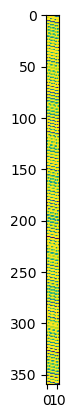

In [28]:
plt.imshow(jac)

In [29]:
jac.shape

(360, 12)

#### Performing GN

In [30]:
#proj = deepcopy(P_mat)
#proj = proj.reshape((12,1))
curr_estimate = np.random.rand(12, 1)

In [31]:
curr_estimate

array([[0.5468849 ],
       [0.27482357],
       [0.59223042],
       [0.89676116],
       [0.40673335],
       [0.55207828],
       [0.27165277],
       [0.45544415],
       [0.40171354],
       [0.24841347],
       [0.50586638],
       [0.31038083]])

In [32]:
iterations = 0
initial_err = get_error(normalized_X_img, X_world, curr_estimate)
err = [initial_err]

while True:
    iterations += 1
    
    # 360 * 12
    J = jacobian(normalized_X_img, X_world, curr_estimate)
    
    # 360 * 1
    e = residual(normalized_X_img, X_world, curr_estimate)

   
    # (12 x 12)  * (12 x 360) * (360 * 1)
    del_est = - np.linalg.pinv(J.T @ J) @ J.T @ e   
    
    with np.printoptions(suppress=True):
        print("change is ", del_est)
        
        
    curr_estimate += del_est.reshape((12,1))

    err_val =  get_error(normalized_X_img, X_world, curr_estimate)
    err.append(err_val)

    if err_val < 1e-3:
        print('\n',f"Converged in {iterations} iterations",)
        break



change is  [ 0.31083334  0.1793069  -0.35122225 -0.45917395 -0.21216875 -1.27271228
  0.3938029   0.43632885  0.07416884 -0.77229528 -1.21232503  0.65328193]

 Converged in 1 iterations


In [33]:
with np.printoptions(suppress=True):
    print(M_ext)

[[ 0.85771824  0.45413047  0.24100817  0.43758721]
 [ 0.1945646  -0.720634    0.66545567  0.891773  ]
 [ 0.47588238 -0.52388181 -0.70645864  0.96366276]
 [ 0.          0.          0.          1.        ]]


In [34]:
with np.printoptions(suppress=True):
    print(curr_estimate.reshape(3, 4))

[[ 0.85771824  0.45413047  0.24100817  0.43758721]
 [ 0.1945646  -0.720634    0.66545567  0.891773  ]
 [ 0.47588238 -0.52388181 -0.70645864  0.96366276]]


### Decomposing the intrinsic matrix into R and C

In [35]:
import scipy

In [36]:
curr_estimate = curr_estimate.reshape(3, 4)

In [37]:
R_mat = curr_estimate[:3, :3]

In [38]:
with np.printoptions(suppress=True):
    print("Estimate for R is \n", R_mat)

Estimate for R is 
 [[ 0.85771824  0.45413047  0.24100817]
 [ 0.1945646  -0.720634    0.66545567]
 [ 0.47588238 -0.52388181 -0.70645864]]


In [39]:
with np.printoptions(suppress=True):
    print("R @ R.T \n", R_mat@R_mat.T)

R @ R.T 
 [[ 1. -0. -0.]
 [-0.  1.  0.]
 [-0.  0.  1.]]


#### Correcting R
Since the linear least square solve is NOT sure to enforce orthogonality of the rotation matrix,
R ∈ SO(3),the rotation matrix must be corrected (if needed).

In [40]:
U, S, Vh = np.linalg.svd(R_mat, full_matrices=False)

In [41]:
R_corrected = U@Vh

In [42]:
with np.printoptions(suppress=True):
    print("Corrected R is \n", R_corrected)

Corrected R is 
 [[ 0.85771824  0.45413047  0.24100817]
 [ 0.1945646  -0.720634    0.66545567]
 [ 0.47588238 -0.52388181 -0.70645864]]


#### Recovering C
$$t = −R^T \times C$$

In [43]:
t = curr_estimate[:, -1]
C_vec = - R_mat@t
with np.printoptions(suppress=True):
    print("Estimate for C is ", C_vec)

Estimate for C is  [-1.01255842 -0.08377188  0.9397315 ]


#### Coincidentally, in this case, the "R" originally obtained WITHOUT correction was same as well. However, this may NOT always be the case.

####  Atleast 6 correspondences needed as each point contributes to only 2 equations and we have a total of 12 variables, even though the number of degrees of freedom is 6.

### -----------------------------------------------

### TODO 2:


2. Given 2D-3D correspondences, X ↔ x, and the intrinsic parameter, K, estimate a camera pose using linear least squares: `[C R] = PnP(X, x, K)` 

* (INPUT) X and x: N × 3 and N × 2 matrices whose row represents correspondences between 3D and 2D points, respectively. 


* (INPUT) K: intrinsic parameter. 

* (OUTPUT) C and R: camera pose (C, R).


    
- Basically, you have to solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  **Run the optimization for different choices of initialization and report your observations**.

- For this set of correspondences report the final reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. Also, report your ground truth, initialised and final estimated transformation matrix. Also, use `np.isclose()` to analyse these 3 matrices closeness.

- Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. 

## Observations:
* Irrespective of the initialization type, the error always converged in the first iteration itself. This is because the residual is linear in the variable to be estimated and hence, it converges in a standard linear least squares style.

### -----------------------------------------------

### TODO 3:

3. The above two sub-task seem to be direct as you were directly taking the image of 3D points but it's not realistically possible. Lets say instead of synthesizing a new image of obtained 3D points in first part, you have been given a new image like below. How would you approach it's camera pose estimation. Briefly explain in 3-4 lines. Note: You already have information available from the previous part(Two view geometry part) of the assignment.

    <img src="./data/3/rgb002615.jpg" alt="image 1" width="400"/> <br>

### Ans:
Assuming that I already have the previous image and the given image is the new image, we can follow the following steps:
* FInd matching features in the 2 images using SIFT
* Estimate the fundamental and essential matrix.
* The essential matrix can be processed to give us 4 candidates for relative pose of camera 1 and 2.
* Since we know the intrinsic parameters, we can triangulate the pixels in the 2 images for each of the candidates.
* We finally choose that candidate (and triangulated points) who satisy the cheirality condition to the maximum extent.